In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import numpy as np
from math import sqrt, pi, log, e
from enum import Enum
import scipy.stats as stat
from scipy.stats import norm
import time



In [14]:
class BSMerton(object):
    def __init__(self, args):
        self.Type = int(args[0])  # 1 for a Call, - 1 for a put
        self.S = float(args[1])  # Underlying asset price
        self.K = float(args[2])  # Option strike K
        self.r = float(args[3])  # Continuous risk fee rate
        self.q = float(args[4])  # Dividend continuous rate
        self.T = float(args[5]) / 365.0  # Compute time to expiry
        self.sigma = float(args[6])  # Underlying volatility
        self.sigmaT = self.sigma * self.T ** 0.5  # sigma*T for reusability
        self.d1 = (log(self.S / self.K) + \
                   (self.r - self.q + 0.5 * (self.sigma ** 2)) \
                   * self.T) / self.sigmaT
        self.d2 = self.d1 - self.sigmaT
        [self.Premium] = self.premium()
        [self.Delta] = self.delta()
        [self.Theta] = self.theta()
        [self.Rho] = self.rho()
        [self.Vega] = self.vega()
        [self.Gamma] = self.gamma()
        [self.Phi] = self.phi()
        [self.Charm] = self.dDeltadTime()
        [self.Vanna] = self.dDeltadVol()

    def premium(self):
        tmpprem = self.Type * (self.S * e ** (-self.q * self.T) * norm.cdf(self.Type * self.d1) - \
                               self.K * e ** (-self.r * self.T) * norm.cdf(self.Type * self.d2))
        return [tmpprem]

    ############################################
    ############ 1st order greeks ##############
    ############################################

    def delta(self):
        dfq = e ** (-self.q * self.T)
        if self.Type == 1:
            return [dfq * norm.cdf(self.d1)]
        else:
            return [dfq * (norm.cdf(self.d1) - 1)]

    # Vega for 1% change in vol
    def vega(self):
        return [0.01 * self.S * e ** (-self.q * self.T) * \
                norm.pdf(self.d1) * self.T ** 0.5]

    # Theta for 1 day change
    def theta(self):
        df = e ** -(self.r * self.T)
        dfq = e ** (-self.q * self.T)
        tmptheta = (1.0 / 365.0) \
                   * (-0.5 * self.S * dfq * norm.pdf(self.d1) * \
                      self.sigma / (self.T ** 0.5) + \
                      self.Type * (self.q * self.S * dfq * norm.cdf(self.Type * self.d1) \
                                   - self.r * self.K * df * norm.cdf(self.Type * self.d2)))
        return [tmptheta]

    def rho(self):
        df = e ** -(self.r * self.T)
        return [self.Type * self.K * self.T * df * 0.01 * norm.cdf(self.Type * self.d2)]

    def phi(self):
        return [0.01 * -self.Type * self.T * self.S * \
                e ** (-self.q * self.T) * norm.cdf(self.Type * self.d1)]

    ############################################
    ############ 2nd order greeks ##############
    ############################################

    def gamma(self):
        return [e ** (-self.q * self.T) * norm.pdf(self.d1) / (self.S * self.sigmaT)]

    # Charm for 1 day change
    def dDeltadTime(self):
        dfq = e ** (-self.q * self.T)
        if self.Type == 1:
            return [
                (1.0 / 365.0) * -dfq * (norm.pdf(self.d1) * ((self.r - self.q) / (self.sigmaT) - self.d2 / (2 * self.T)) \
                                        + (-self.q) * norm.cdf(self.d1))]
        else:
            return [
                (1.0 / 365.0) * -dfq * (norm.pdf(self.d1) * ((self.r - self.q) / (self.sigmaT) - self.d2 / (2 * self.T)) \
                                        + self.q * norm.cdf(-self.d1))]

    # Vanna for 1% change in vol
    def dDeltadVol(self):
        return [0.01 * -e ** (-self.q * self.T) * self.d2 / self.sigma * norm.pdf(self.d1)]

    # Vomma
    def dVegadVol(self):
        return [0.01 * -e ** (-self.q * self.T) * self.d2 / self.sigma * norm.pdf(self.d1)]

In [15]:
class BSMertonImpledVolFinder(object):
    def __init__(self, args):
        self.Type = int(args[0])  # 1 for a Call, - 1 for a put
        self.S = float(args[1])  # Underlying asset price
        self.K = float(args[2])  # Option strike K
        self.r = float(args[3])  # Continuous risk fee rate
        self.q = float(args[4])  # Dividend continuous rate
        self.T = float(args[5]) / 365.0  # Compute time to expiry
        self.Premium = float(args[6])  # Option premium
        self.sigma = self.implied_volatility()

    def black_scholes_price(self, sigma):
        sigmaT = sigma * self.T ** 0.5
        d1 = (log(self.S / self.K) + (self.r - self.q + 0.5 * (sigma ** 2)) * self.T) / sigmaT
        d2 = d1 - sigmaT
        price = self.Type * (self.S * e ** (-self.q * self.T) * norm.cdf(self.Type * d1) - \
                             self.K * e ** (-self.r * self.T) * norm.cdf(self.Type * d2))
        return price

    def implied_volatility(self, epsilon=0.0001):
        # Use the bisection method to find the implied volatility that matches the given option premium
        lower = 0.001
        upper = 10.0
        mid = (lower + upper) / 2.0
        diff = self.Premium - self.black_scholes_price(mid)
        while abs(diff) > epsilon:
            if diff > 0:
                lower = mid
            else:
                upper = mid
            mid = (lower + upper) / 2.0
            diff = self.Premium - self.black_scholes_price(mid)
        return mid
    

In [32]:
# Call = 1  Put = -1   [Option,Price, Strike,Continuous rf rate, dividend, days to exp,vol]

Implied_Volatility = [.1,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,65,.7,.75,.8]

AAPL_Call= [1,165,165,0.0425,0.0053,14,Implied_Volatility]
AAPL_Put= [-1,165,165,0.0425,0.0053,14,Implied_Volatility]


def ArrayOfPricesGivenVols(OptionParams,IV_Array):
    prices = []
    for i in IV_Array:
        OptionParams[6] = i
        prices.append(BSMerton(OptionParams).Premium)
    return prices

AAPLCallSide= ArrayOfPricesGivenVols(AAPL_Call,Implied_Volatility)
AAPLPutSide= ArrayOfPricesGivenVols(AAPL_Put,Implied_Volatility)






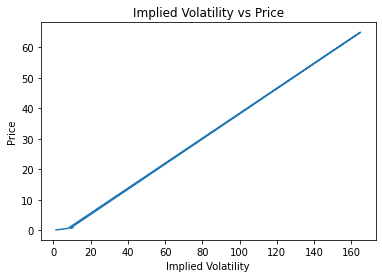

In [84]:
AAPLCallSide
plt.plot(AAPLCallSide, Implied_Volatility)
plt.xlabel('Implied Volatility')
plt.ylabel('Price')
plt.title('Implied Volatility vs Price')
plt.show()

In [79]:
AAPLPutSide

[1.173782017848609,
 1.8165913138241478,
 2.4599232051813402,
 3.103421072678273,
 3.746955662812084,
 4.390462753433198,
 5.033902524676748,
 5.677246009596956,
 6.320469673507574,
 6.9635529502028675,
 7.606477010470343,
 164.7312464770918,
 8.891777158342094,
 9.534119598064947,
 10.176235157940582]

In [14]:
AAPL_Call_Sanity_Check = [1,165,165,0.0425,0.0053,14,.8]
BSMerton(AAPL_Call_Sanity_Check).Premium



10.411449592063775

In [25]:
AAPL_Options = pd.read_csv("AAPL_Options.csv")
AAPL_Options.head()



,Stock,Expiration,Type,Strike,Last Price
0,AAPL,4/21/2023,Call,125,27.300
1,AAPL,4/21/2023,Call,130,22.575
2,AAPL,4/21/2023,Call,135,17.750
3,AAPL,4/21/2023,Call,140,13.850
4,AAPL,4/21/2023,Call,145,9.975


In [43]:
Strike = list(AAPL_Options.loc[0:10,"Strike"])

Strike_string =  ','.join(str(x) for x in Strike)
Strike_string

'125,130,135,140,145,150,155,160,165,170,175'

In [51]:
strike_list = list(AAPL_Options.loc[0:10,"Strike"])

0     125
1     130
2     135
3     140
4     145
5     150
6     155
7     160
8     165
9     170
10    175
Name: Strike, dtype: int64

In [44]:
Price = list(AAPL_Options.loc[0:10,"Last Price"])

Price_string = ','.join(str(x) for x in Price)



In [70]:
strike_list = list(AAPL_Options.loc[0:10,"Strike"])
strike_list_put = list(AAPL_Options.loc[11:21,"Strike"])
price_list = list(AAPL_Options.loc[0:10,"Last Price"])
price_list_put = list(AAPL_Options.loc[11:21,"Last Price"])

# ImpVolatility = ArrayOfVolsGivenPrices(AAPL_IV_Call, strike_list, price_list)


In [58]:
strike_list

[125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175]

In [71]:
strike_list_float_call = [float(strike) for strike in strike_list]
strike_list_float_put = [float(strike) for strike in strike_list_put]
price_list_float_call = [float(price) for price in price_list]
price_list_float_put = [float(price) for price in price_list_put]

In [72]:
strike_list_float_put

[125.0, 130.0, 135.0, 140.0, 145.0, 150.0, 155.0, 160.0, 165.0, 170.0, 175.0]

In [73]:


AAPL_IV_Call = [1,151.03,strike_list_float_call,0.0425,0.0053,49,price_list_float_call]
AAPL_IV_Put = [-1,151.03,strike_list_float_put,0.0425,0.0053,49,price_list_float_put]




#49 days




def ArrayOfVolsGivenPrices(OptionParams, strikes, prices):
    ImpVolatility = []
    for i in range(len(strikes)):
        OptionParams[2] = strikes[i]
        OptionParams[6] = prices[i]
        ImpVolatility.append(BSMertonImpledVolFinder(OptionParams).implied_volatility())
    return ImpVolatility


impVolatilityCallSide =ArrayOfVolsGivenPrices(AAPL_IV_Call,strike_list_float_call,price_list_float_call)
impVolatilityPutSide =ArrayOfVolsGivenPrices(AAPL_IV_Put,strike_list_float_put,price_list_float_put)

impVolatilityCallSide
impVolatilityPutSide

[0.3346000595092773,
 0.314479543685913,
 0.29777284049987784,
 0.28098985099792473,
 0.26753485202789307,
 0.25513832569122313,
 0.24241758251190182,
 0.2456978940963745,
 0.2734947204589844,
 0.29540796470642094,
 0.3612430553436279]

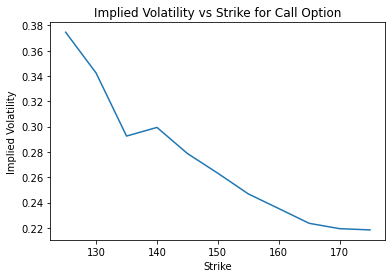

In [76]:
impVolatilityCallSide

#take values from Imp Volatility Call side and plot it on a graph
plt.plot(strike_list_float_call, impVolatilityCallSide)
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs Strike for Call Option')
plt.show()



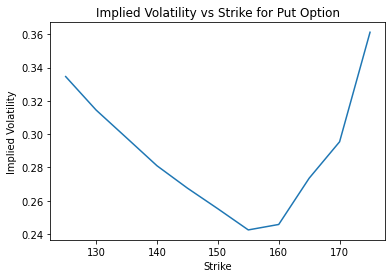

In [77]:
impVolatilityPutSide

#take values from Imp Volatility Put side and plot it on a graph
plt.plot(strike_list_float_put, impVolatilityPutSide)
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs Strike for Put Option')
plt.show()


In [2]:
Dailyreturns = pd.read_csv("DailyPrices.csv")
Option_Portfolio = pd.read_csv("problem3.csv",parse_dates=["ExpirationDate"])
Option_Portfolio.head()

,Portfolio,Type,Underlying,Holding,OptionType,ExpirationDate,Strike,CurrentPrice
0,Straddle,Option,AAPL,1,Call,2023-04-21,150.0,6.80
1,Straddle,Option,AAPL,1,Put,2023-04-21,150.0,4.85
2,SynLong,Option,AAPL,1,Call,2023-04-21,150.0,6.80
3,SynLong,Option,AAPL,-1,Put,2023-04-21,150.0,4.85
4,CallSpread,Option,AAPL,1,Call,2023-04-21,150.0,6.80


In [31]:

import pandas as pd
import numpy as np
import sklearn
import scipy.stats as stats
from scipy.stats import skew, kurtosis
from scipy.stats import describe
from scipy.stats import norm
from scipy.stats import kurtosis
from scipy.stats import t
from scipy.stats import multivariate_t
from scipy.integrate import quad
from scipy.stats.mstats import gmean
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import scipy.linalg
import pprint as pprint
import time as time
from sklearn.decomposition import PCA
import datetime as dt
from numpy.linalg import eig
import QuantRiskTools as QRT


In [9]:
Dailyreturns = Dailyreturns.drop(Dailyreturns.columns[0], axis=1)
DailyReturns = QRT.calculateReturns(Dailyreturns, "Geometric")
DailyReturns.head()


,AAPL,MSFT,AMZN,TSLA,GOOGL,GOOG,META,NVDA,BRK-B,JPM,...,PNC,MDLZ,MO,ADI,GILD,LMT,SYK,GM,TFC,TJX
1,2.315237e-02,0.018542,0.008658,0.053291,0.007987,0.008319,0.015158,0.091812,0.006109,0.014624,...,0.012807,-0.004082,0.004592,0.052344,0.003600,-0.012275,0.033021,0.026240,0.028572,0.013237
2,2.173132e-02,0.017353,0.018905,0.054387,0.016322,0.016168,-0.005328,0.092471,0.004359,0.016460,...,0.019651,-0.006501,0.010381,0.093259,0.012927,-0.000181,0.036494,0.041942,0.027143,-0.013090
3,2.220446e-16,-0.012437,-0.003316,0.000674,-0.022040,-0.022110,-0.045889,0.009890,-0.002323,-0.006951,...,-0.015985,-0.001210,0.025554,0.041889,0.002946,0.004651,0.004512,0.008678,-0.007143,-0.041477
4,-9.355810e-03,-0.021948,-0.016534,-0.021444,-0.037801,-0.035717,-0.053009,-0.025755,0.001655,-0.002295,...,-0.016620,-0.002117,0.032941,0.041434,-0.000982,-0.001318,-0.009223,0.004132,-0.010794,-0.027063
5,-2.700144e-02,-0.022661,-0.032027,-0.061923,-0.042151,-0.043588,-0.071750,-0.036140,-0.000382,-0.004066,...,-0.007284,0.004989,0.023757,0.044811,-0.002127,-0.001990,-0.000958,-0.033678,-0.013016,-0.040300


In [13]:
AAPLReturns = pd.DataFrame(DailyReturns.AAPL)
AAPLReturns
AAPLMean =AAPLReturns.mean()
DailyReturnsAAPLMeansRemoved = AAPLReturns - AAPLMean

DailyReturnsAAPLMeansRemoved= DailyReturnsAAPLMeansRemoved.dropna()

DailyReturnsAAPLMeansRemoved.tail()

,AAPL
244,0.021298
245,0.004821
246,0.022190
247,0.005951
248,-0.000294


In [18]:
AAPL_ARIMA_Model= sm.tsa.ARIMA(DailyReturnsAAPLMeansRemoved,order=(1,0,0))
modelOutput = AAPL_ARIMA_Model.fit()
modelOutput.summary()

c:\Users\Moneybag Mike\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Moneybag Mike\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Moneybag Mike\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   AAPL   No. Observations:                  248
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 620.649
Date:                Sat, 25 Mar 2023   AIC                          -1235.299
Time:                        03:09:40   BIC                          -1224.758
Sample:                             0   HQIC                         -1231.056
                                - 248                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0114      0.029      0.392      0.695      -0.046       0.068
ar.L1          0.9650      0.018     55.035      0.000       0.931       0.999
sigma2         0.0004    3.2e-05     12.121      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):                 1.85
Prob(Q):                              0.55   Prob(JB):                         0.40
Heteroskedasticity (H):               0.80   Skew:                             0.01
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:

Option_Portfolio
# current_date = 3/3/2023
# Expiration_Date = Option_Portfolio["ExpirationDate"]
# Expiration_Date


,Portfolio,Type,Underlying,Holding,OptionType,ExpirationDate,Strike,CurrentPrice
0,Straddle,Option,AAPL,1,Call,2023-04-21,150.0,6.80
1,Straddle,Option,AAPL,1,Put,2023-04-21,150.0,4.85
2,SynLong,Option,AAPL,1,Call,2023-04-21,150.0,6.80
3,SynLong,Option,AAPL,-1,Put,2023-04-21,150.0,4.85
4,CallSpread,Option,AAPL,1,Call,2023-04-21,150.0,6.80
5,CallSpread,Option,AAPL,-1,Call,2023-04-21,160.0,2.21
6,PutSpread,Option,AAPL,1,Put,2023-04-21,150.0,4.85
7,PutSpread,Option,AAPL,-1,Put,2023-04-21,140.0,1.84
8,Stock,Stock,AAPL,1,NaN,NaT,NaN,151.03
9,Call,Option,AAPL,1,Call,2023-04-21,150.0,6.80


In [24]:
#make an array of implied volatility for optionPortfolio for Strike

Option_Portfolio_Strike = list(Option_Portfolio.loc[0:10,"Strike"])
Option_Portfolio_Strike_float = [float(strike) for strike in Option_Portfolio_Strike]
Option_Portfolio_Strike_float


[150.0, 150.0, 150.0, 150.0, 150.0, 160.0, 150.0, 140.0, nan, 150.0, 150.0]

6.799999999999997
6.800000000000004
6.799999999999997
6.799999999999983
6.800000000000004
6.8000000000000185
6.799999999999997
6.800000000000011
6.799999999999997
6.800000000000011
6.799999999999997
6.799999999999997
6.799999999999997
7.5145161997330945
8.829789912955363
10.145063626177603
11.46033733939987
12.77561105262214
-1.3477364889546756e-51
-6.941865245198756e-20
2.210000000000001
2.20999999999999
2.209999999999976
2.2100000000000115
2.2100000000000044
2.2099999999999653
2.210000000000001
2.2099999999999795
2.2099999999999937
2.210000000000008
2.210000000000001
2.210000000000015
2.210000000000008
2.2099999999999937
2.210000000000008
2.2099999999999937
2.210000000000008
2.8070000420218264
4.122273755244066
-3.691167459509262e-120


c:\Users\Moneybag Mike\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


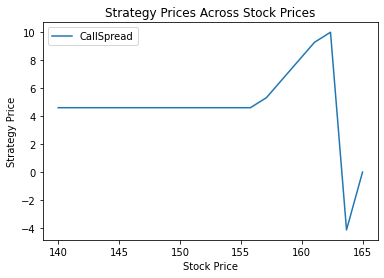

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import log, e
from scipy.stats import norm

# Add the given BSMerton and BSMertonImpledVolFinder classes here
class BSMerton(object):
    def __init__(self, args):
        self.Type = int(args[0])  # 1 for a Call, - 1 for a put
        self.S = float(args[1])  # Underlying asset price
        self.K = float(args[2])  # Option strike K
        self.r = float(args[3])  # Continuous risk fee rate
        self.q = float(args[4])  # Dividend continuous rate
        self.T = float(args[5]) / 365.0  # Compute time to expiry
        self.sigma = float(args[6])  # Underlying volatility
        self.sigmaT = self.sigma * self.T ** 0.5  # sigma*T for reusability
        self.d1 = (log(self.S / self.K) + \
                   (self.r - self.q + 0.5 * (self.sigma ** 2)) \
                   * self.T) / self.sigmaT
        self.d2 = self.d1 - self.sigmaT
        [self.Premium] = self.premium()
        [self.Delta] = self.delta()
        [self.Theta] = self.theta()
        [self.Rho] = self.rho()
        [self.Vega] = self.vega()
        [self.Gamma] = self.gamma()
        [self.Phi] = self.phi()
        [self.Charm] = self.dDeltadTime()
        [self.Vanna] = self.dDeltadVol()

    def premium(self):
        tmpprem = self.Type * (self.S * e ** (-self.q * self.T) * norm.cdf(self.Type * self.d1) - \
                               self.K * e ** (-self.r * self.T) * norm.cdf(self.Type * self.d2))
        return [tmpprem]

    ############################################
    ############ 1st order greeks ##############
    ############################################

    def delta(self):
        dfq = e ** (-self.q * self.T)
        if self.Type == 1:
            return [dfq * norm.cdf(self.d1)]
        else:
            return [dfq * (norm.cdf(self.d1) - 1)]

    # Vega for 1% change in vol
    def vega(self):
        return [0.01 * self.S * e ** (-self.q * self.T) * \
                norm.pdf(self.d1) * self.T ** 0.5]

    # Theta for 1 day change
    def theta(self):
        df = e ** -(self.r * self.T)
        dfq = e ** (-self.q * self.T)
        tmptheta = (1.0 / 365.0) \
                   * (-0.5 * self.S * dfq * norm.pdf(self.d1) * \
                      self.sigma / (self.T ** 0.5) + \
                      self.Type * (self.q * self.S * dfq * norm.cdf(self.Type * self.d1) \
                                   - self.r * self.K * df * norm.cdf(self.Type * self.d2)))
        return [tmptheta]

    def rho(self):
        df = e ** -(self.r * self.T)
        return [self.Type * self.K * self.T * df * 0.01 * norm.cdf(self.Type * self.d2)]

    def phi(self):
        return [0.01 * -self.Type * self.T * self.S * \
                e ** (-self.q * self.T) * norm.cdf(self.Type * self.d1)]

    ############################################
    ############ 2nd order greeks ##############
    ############################################

    def gamma(self):
        return [e ** (-self.q * self.T) * norm.pdf(self.d1) / (self.S * self.sigmaT)]

    # Charm for 1 day change
    def dDeltadTime(self):
        dfq = e ** (-self.q * self.T)
        if self.Type == 1:
            return [
                (1.0 / 365.0) * -dfq * (norm.pdf(self.d1) * ((self.r - self.q) / (self.sigmaT) - self.d2 / (2 * self.T)) \
                                        + (-self.q) * norm.cdf(self.d1))]
        else:
            return [
                (1.0 / 365.0) * -dfq * (norm.pdf(self.d1) * ((self.r - self.q) / (self.sigmaT) - self.d2 / (2 * self.T)) \
                                        + self.q * norm.cdf(-self.d1))]

    # Vanna for 1% change in vol
    def dDeltadVol(self):
        return [0.01 * -e ** (-self.q * self.T) * self.d2 / self.sigma * norm.pdf(self.d1)]

    # Vomma
    def dVegadVol(self):
        return [0.01 * -e ** (-self.q * self.T) * self.d2 / self.sigma * norm.pdf(self.d1)]
    

from scipy.optimize import fsolve

class BSMertonImpledVolFinder(object):
    def __init__(self, args):
        self.Type = int(args[0])  # 1 for a Call, -1 for a put
        self.S = float(args[1])  # Underlying asset price
        self.K = float(args[2])  # Option strike K
        self.r = float(args[3])  # Continuous risk-free rate
        self.q = float(args[4])  # Dividend continuous rate
        self.T = float(args[5]) / 365.0  # Compute time to expiry
        self.Premium = float(args[6])  # Option premium
        self.sigma = self.implied_volatility()

    def black_scholes_price(self, sigma):
        sigmaT = sigma * self.T ** 0.5
        d1 = (log(self.S / self.K) + (self.r - self.q + 0.5 * (sigma ** 2)) * self.T) / sigmaT
        d2 = d1 - sigmaT
        price = self.Type * (self.S * e ** (-self.q * self.T) * norm.cdf(self.Type * d1) - \
                             self.K * e ** (-self.r * self.T) * norm.cdf(self.Type * d2))
        return price

    def option_price_difference(self, sigma):
        return self.Premium - self.black_scholes_price(sigma)

    def implied_volatility(self):
        initial_guess = 0.2
        result = fsolve(self.option_price_difference, initial_guess)
        return result[0]




# Helper function to get the option price for different strategies
def get_option_price(option_data, stock_price, r, q, current_date):
    T = (pd.to_datetime(option_data['ExpirationDate']) - pd.to_datetime(current_date)).days
    option_type = 1 if option_data['OptionType'] == 'Call' else -1
    option_args = [option_type, stock_price, option_data['Strike'], r, q, T, option_data['CurrentPrice']]
    implied_vol = BSMertonImpledVolFinder(option_args).sigma
    option_args_with_vol = option_args[:-1] + [implied_vol]
    bsmerton = BSMerton(option_args_with_vol)
    option_price = bsmerton.Premium  #Console log
    print(option_price)  # Console log
    return bsmerton.Premium


# Function to plot the price of the strategies
def plot_strategy_prices(df, r, q, current_date, selected_strategy):
    stock_prices = np.linspace(140, 165, 20)
    strategy_prices = {selected_strategy: np.zeros_like(stock_prices)}

    df_filtered = df[df['Portfolio'] == selected_strategy]

    for _, row in df_filtered.iterrows():
        strategy = row['Portfolio']
        if row['Type'] == 'Option':
            for idx, stock_price in enumerate(stock_prices):
                option_price = get_option_price(row, stock_price, r, q, current_date)
                strategy_prices[strategy][idx] += row['Holding'] * option_price
        elif row['Type'] == 'Stock':
            strategy_prices[strategy] += row['Holding'] * stock_prices

    for strategy, prices in strategy_prices.items():
        plt.plot(stock_prices, prices, label=strategy)

    plt.legend()
    plt.xlabel("Stock Price")
    plt.ylabel("Strategy Price")
    plt.title("Strategy Prices Across Stock Prices")
    plt.show()

# Example usage
csv_file = 'problem3.csv'  # Replace with your CSV file path
df = pd.read_csv(csv_file, delimiter=',')  # Assuming your CSV uses tab as a delimiter

r = 0.0425  # Continuous risk-free rate
q = 0.0053  # Dividend continuous rate
current_date = '2023-03-25'

plot_strategy_prices(df, r, q, current_date,"CallSpread")


In [14]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
    print("GPU(s) details:")
    for device in tf.config.list_physical_devices('GPU'):
        print(device)
else:
    print("GPU is not available")


AttributeError: module 'tensorflow' has no attribute 'config'

In [ ]:
import tensorflow as tf
class BSMerton(tf.Module):
    def __init__(self, args):
        super().__init__()
        self.Type = args[0]
        self.S = args[1]
        self.K = args[2]
        self.r = args[3]
        self.q = args[4]
        self.T = args[5]
        self.sigma = args[6]

    def d1(self):
        d1 = (tf.math.log(self.S / self.K) + (self.r - self.q + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * tf.math.sqrt(self.T))
        return d1

    def d2(self):
        d2 = self.d1() - self.sigma * tf.math.sqrt(self.T)
        return d2

    def value(self):
        call_value = self.S * tf.math.exp(-self.q * self.T) * norm.cdf(self.d1()) - self.K * tf.math.exp(-self.r * self.T) * norm.cdf(self.d2())
        put_value = self.K * tf.math.exp(-self.r * self.T) * norm.cdf(-self.d2()) - self.S * tf.math.exp(-self.q * self.T) * norm.cdf(-self.d1())
        return self.Type * (call_value - put_value)
    
class BSMertonImpledVolFinder(tf.Module):
    def __init__(self, args):
        super().__init__()
        self.Type = args[0]
        self.S = args[1]
        self.K = args[2]
        self.r = args[3]
        self.q = args[4]
        self.T = args[5]
        self.C = args[6]
        self.sigma = self.calculate_implied_volatility()

    def calculate_implied_volatility(self):
        sigma = tf.Variable(0.5, dtype=tf.float64)
        optimizer = tf.keras.optimizers.SLSQP()

        def loss_fn():
            option_args = [self.Type, self.S, self.K, self.r, self.q, self.T, sigma]
            bsmerton = BSMerton(option_args)
            return tf.abs(bsmerton.value() - self.C)

        optimizer.minimize(loss_fn, [sigma])
        return sigma.numpy()

def get_option_price(option_data, stock_prices, r, q, current_date):
    option_type = 1 if option_data['OptionType'] == 'Call' else -1
    T = (pd.to_datetime(option_data['ExpirationDate']) - pd.to_datetime(current_date)).days / 365
    option_args = [option_type, stock_prices, option_data['Strike'], r, q, T, option_data['CurrentPrice']]
    implied_vol = BSMertonImpledVolFinder(option_args).sigma
    option_args_with_vol = option_args[:-1] + [implied_vol]
    bsmerton = BSMerton(option_args_with_vol)
    return bsmerton.value

